# Alexander Jannaeus vs John Hyrcanus
## Data Loading

In [157]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [158]:
from PIL import UnidentifiedImageError


# Load images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                images.append(img)
            except UnidentifiedImageError:
                print(f"Skipped non-image file: {filename}")
    return images

In [159]:
# Paths and Loading
path_alex = 'alexander'
path_john = 'john'
images_alex = load_images_from_folder(path_alex)
images_john = load_images_from_folder(path_john)

Skipped non-image file: .DS_Store
Skipped non-image file: .DS_Store


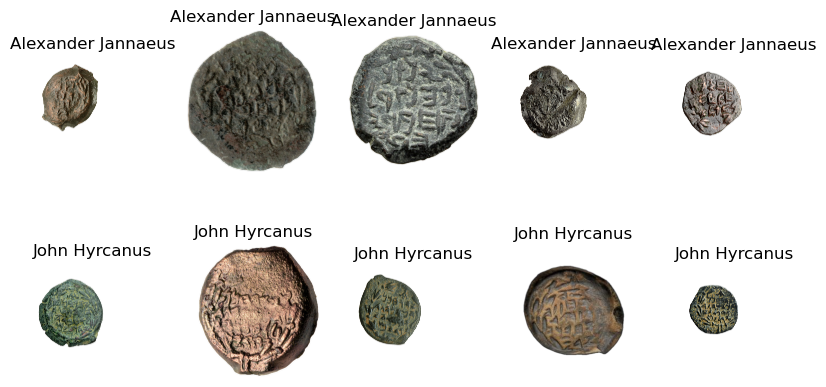

In [160]:
# Display a few samples
plt.figure(figsize=(10, 5))
for i, img in enumerate(images_alex[:5]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("Alexander Jannaeus")
    plt.axis('off')
for i, img in enumerate(images_john[:5]):
    plt.subplot(2, 5, i+6)
    plt.imshow(img)
    plt.title("John Hyrcanus")
    plt.axis('off')
plt.show()

In [161]:
# Count the images for each king
num_images_alex = len(images_alex)
num_images_john = len(images_john)

print(f"Number of images for Alexander: {num_images_alex}")
print(f"Number of images for John: {num_images_john}")

Number of images for Alexander: 189
Number of images for John: 244


## Data Preprocessing

In [162]:
# Preprocess function
IMG_SIZE = (244, 244)
# Function to preprocess images for coin classification (original RGB version)
def preprocess_image_for_classification(image):
    # RGB version: skip grayscale conversion and use the image as-is.
    # Convert to RGB (if images were loaded with RGBA)
    if image.shape[-1] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

    # gray = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)  # Convert to grayscale
    # enhanced = cv2.equalizeHist(gray)  # contrast enhancement if needed
    
    
    # Resize image
    resized_img = cv2.resize(image, IMG_SIZE)

    # Normalize the image
    return resized_img / 255.0

In [163]:
# Update the main preprocessing function to apply these steps to each image
def preprocess_images(image_list):
    processed_images = []
    for img in image_list:
        # Convert to numpy array and preprocess
        img_array = np.array(img)
        processed_img = preprocess_image_for_classification(img_array)
        processed_images.append(processed_img)
    return np.array(processed_images)

In [164]:
# Apply preprocessing
images_alex_processed = preprocess_images(images_alex)
images_john_processed = preprocess_images(images_john)

In [165]:
# Create labels and combine data
labels_alex = np.zeros(len(images_alex_processed))
labels_john = np.ones(len(images_john_processed))
X = np.concatenate((images_alex_processed, images_john_processed), axis=0)
y = np.concatenate((labels_alex, labels_john), axis=0)

In [166]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [167]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (389, 244, 244, 3)
Testing data shape: (44, 244, 244, 3)
Training labels shape: (389,)
Testing labels shape: (44,)


In [168]:
# # Reshape X_train and X_test to add a single channel dimension for grayscale
# X_train = X_train.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
# X_test = X_test.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
# 
# # Verify shapes
# print(f"Training data shape after reshaping: {X_train.shape}")
# print(f"Testing data shape after reshaping: {X_test.shape}")

In [169]:
# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

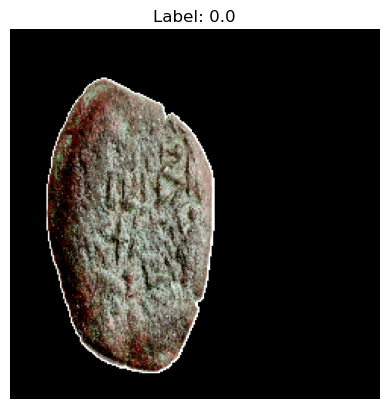

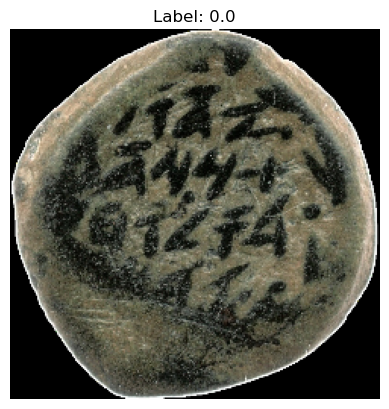

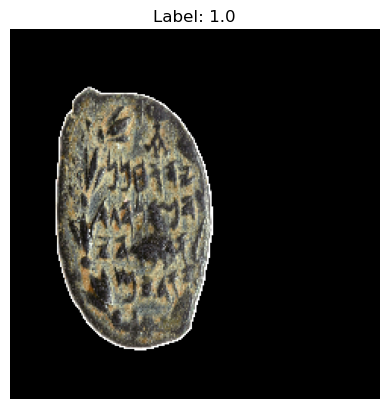

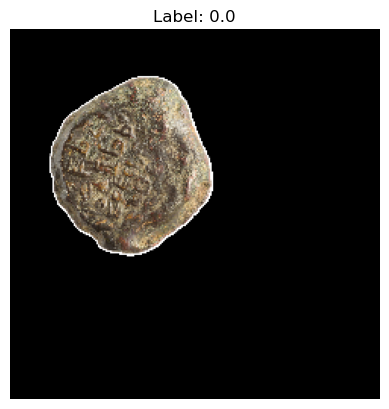

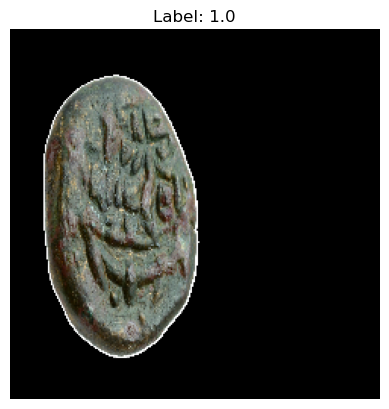

In [170]:
# Display a few training samples with labels
for i in range(5):
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
    plt.show()

## Model Building

In [171]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

### MobileNetV2

In [172]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce feature dimensions
x = Dense(64, activation='relu')(x)  # Dense layer for additional learning
x = Dropout(0.3)(x)  # Dropout to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Final model
modelMNV2 = Model(inputs=base_model.input, outputs=predictions)

In [173]:
# Compile model
modelMNV2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [174]:
# Train the model
historyMNV2 = modelMNV2.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = modelMNV2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/20


2024-11-13 10:35:28.355542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 4s 130ms/step - loss: 0.7279 - accuracy: 0.5193 - val_loss: 0.6666 - val_accuracy: 0.6136
Epoch 2/20
25/25 [==============================] - 3s 115ms/step - loss: 0.6876 - accuracy: 0.5707 - val_loss: 0.6511 - val_accuracy: 0.6818
Epoch 3/20
25/25 [==============================] - 3s 113ms/step - loss: 0.6503 - accuracy: 0.6144 - val_loss: 0.6389 - val_accuracy: 0.6818
Epoch 4/20
25/25 [==============================] - 3s 115ms/step - loss: 0.6359 - accuracy: 0.6350 - val_loss: 0.6211 - val_accuracy: 0.7273
Epoch 5/20
25/25 [==============================] - 3s 113ms/step - loss: 0.6234 - accuracy: 0.6401 - val_loss: 0.6070 - val_accuracy: 0.7045
Epoch 6/20
25/25 [==============================] - 3s 117ms/step - loss: 0.6156 - accuracy: 0.6530 - val_loss: 0.5860 - val_accuracy: 0.7500
Epoch 7/20
25/25 [==============================] - 3s 115ms/step - loss: 0.6019 - accuracy: 0.6761 - val_loss: 0.5820 - val_accuracy: 0.7045
Epoch 8/20
25/25 

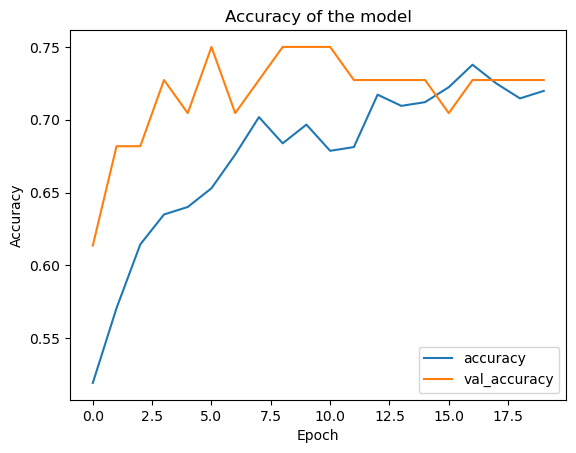

In [175]:
plt.plot(historyMNV2.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(historyMNV2.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### VGG16

In [176]:
from tensorflow.keras.applications import VGG16
# VGG16 model with pre-trained weights
base_model = VGG16(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
# Freeze the base model's layers to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce feature dimensions
x = Dense(64, activation='relu')(x)  # Dense layer for additional learning
x = Dropout(0.3)(x)  # Dropout to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Final model
modelVGG16 = Model(inputs=base_model.input, outputs=predictions)


In [177]:
# Compile model
modelVGG16.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [178]:
# Train the model
historyVGG16 = modelVGG16.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = modelVGG16.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/20


2024-11-13 10:36:35.747523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 33s 1s/step - loss: 0.7675 - accuracy: 0.4499 - val_loss: 0.7103 - val_accuracy: 0.4091
Epoch 2/20
25/25 [==============================] - 32s 1s/step - loss: 0.7119 - accuracy: 0.4679 - val_loss: 0.6924 - val_accuracy: 0.5682
Epoch 3/20
25/25 [==============================] - 31s 1s/step - loss: 0.7018 - accuracy: 0.5398 - val_loss: 0.6880 - val_accuracy: 0.5682
Epoch 4/20
25/25 [==============================] - 30s 1s/step - loss: 0.7028 - accuracy: 0.5141 - val_loss: 0.6852 - val_accuracy: 0.5682
Epoch 5/20
25/25 [==============================] - 30s 1s/step - loss: 0.6903 - accuracy: 0.5450 - val_loss: 0.6841 - val_accuracy: 0.5682
Epoch 6/20
25/25 [==============================] - 30s 1s/step - loss: 0.7114 - accuracy: 0.5219 - val_loss: 0.6802 - val_accuracy: 0.5682
Epoch 7/20
25/25 [==============================] - 32s 1s/step - loss: 0.6939 - accuracy: 0.5604 - val_loss: 0.6772 - val_accuracy: 0.5682
Epoch 8/20
25/25 [=============

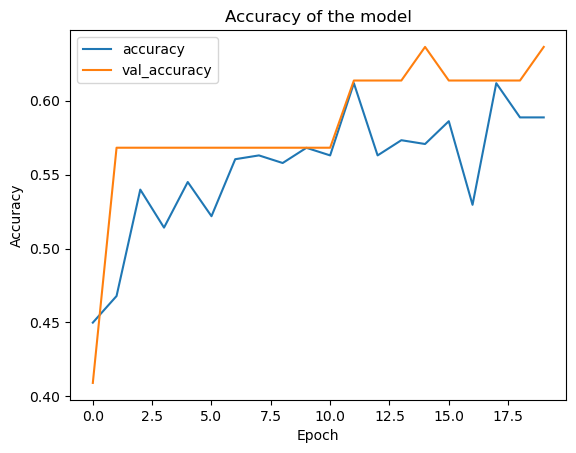

In [179]:
plt.plot(historyVGG16.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(historyVGG16.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Custom CNN

In [193]:
# Define model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [194]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [195]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [196]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/20


2024-11-13 10:50:25.244962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 3s 112ms/step - loss: 0.7309 - accuracy: 0.5681 - val_loss: 0.6539 - val_accuracy: 0.5909
Epoch 2/20
25/25 [==============================] - 3s 109ms/step - loss: 0.6930 - accuracy: 0.5398 - val_loss: 0.6802 - val_accuracy: 0.5682
Epoch 3/20
25/25 [==============================] - 3s 124ms/step - loss: 0.6881 - accuracy: 0.5758 - val_loss: 0.6714 - val_accuracy: 0.6136
Epoch 4/20
25/25 [==============================] - 3s 115ms/step - loss: 0.6839 - accuracy: 0.5810 - val_loss: 0.6631 - val_accuracy: 0.6136
Epoch 5/20
25/25 [==============================] - 3s 111ms/step - loss: 0.6762 - accuracy: 0.5835 - val_loss: 0.6522 - val_accuracy: 0.6136
Epoch 6/20
25/25 [==============================] - 3s 112ms/step - loss: 0.6835 - accuracy: 0.5450 - val_loss: 0.6671 - val_accuracy: 0.6136
Epoch 7/20
25/25 [==============================] - 3s 110ms/step - loss: 0.6795 - accuracy: 0.5990 - val_loss: 0.6694 - val_accuracy: 0.6136
Epoch 8/20
25/25 

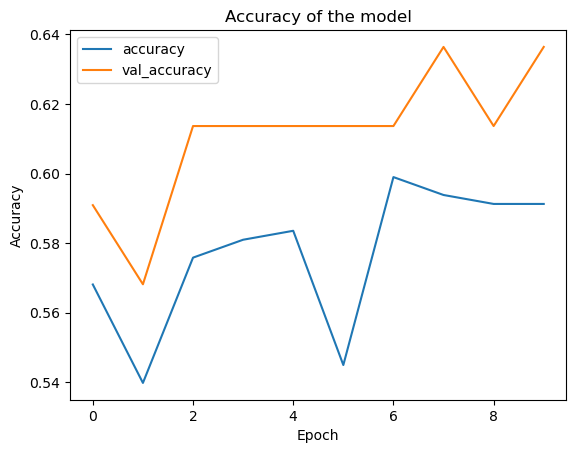

In [197]:
plt.plot(history.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()